Installs the 🤗 Hugging Face diffusers library.

This library provides tools to train, run, and customize diffusion models, which are used in state-of-the-art generative models like Stable Diffusion.



In [ ]:
%pip install -q diffusers






1. **`DDPMScheduler`** (Denoising Diffusion Probabilistic Models Scheduler)

* **What it is**: A scheduler that defines the noise schedule (i.e., how noise is added/removed) during training and inference in a DDPM (Denoising Diffusion Probabilistic Model).
* **Role**: Controls the **forward diffusion process** (adding noise) and the **reverse denoising process** (sampling).
* **Key parameters**: `num_train_timesteps`, `beta_start`, `beta_end`, `schedule` type (linear, cosine, etc.)

2. **`UNet2DModel`**

* **What it is**: A 2D **U-Net architecture** used to predict noise in images during the reverse diffusion process.
* **Role**: The **core model** that learns to remove noise from images, timestep by timestep.
* **Input**: A noisy image, timestep `t`, and sometimes a conditioning input (e.g., text embedding in Stable Diffusion).
* **Output**: Predicted noise (or image residual), used to denoise the sample.



| Component       | Purpose                                           |
| --------------- | ------------------------------------------------- |
| `DDPMScheduler` | Schedules the noise levels at each timestep       |
| `UNet2DModel`   | Predicts and removes noise (main denoising model) |

These are the **building blocks** for a diffusion model pipeline that generates or reconstructs images from noise.




In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# The Data

In [3]:
dataset=torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.05MB/s]


In [4]:
train_dataloader=DataLoader(dataset,batch_size=8,shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 3, 7, 0, 1, 3, 2, 4])


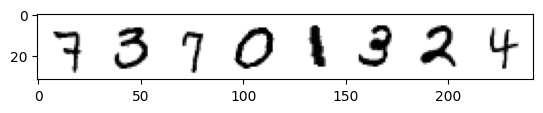

In [5]:
x,y = next(iter(train_dataloader))
print("Input shape:",x.shape)
print("Labels:",y)
plt.imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")

# The Corruption Process

| Index | Meaning               | Size                                |
| ----- | --------------------- | ----------------------------------- |
| 0     | Batch size (inferred) | `-1` means infer from current shape |
| 1     | Channel dimension     | 1                                   |
| 2     | Height                | 1                                   |
| 3     | Width                 | 1                                   |


In [6]:
def corrupt(x,amount):
  noise=torch.rand_like(x)
  amount=amount.view(-1,1,1,1)
  return x*(1-amount)+noise*amount

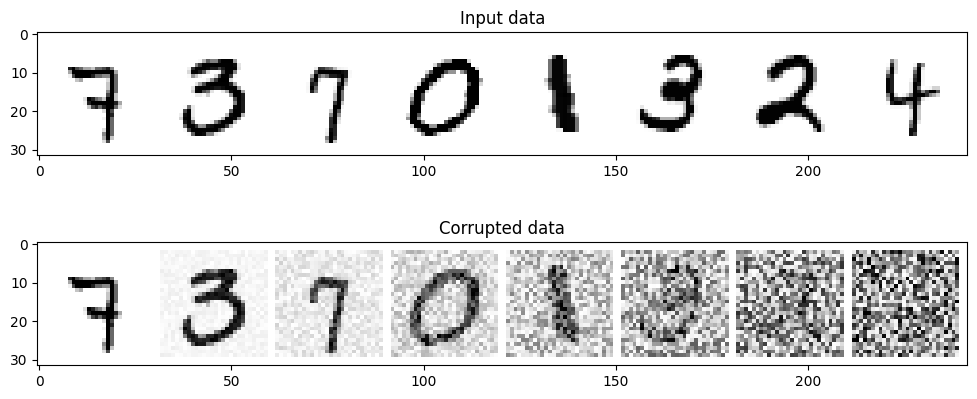

In [8]:
# Plotting the input data
fig,axs=plt.subplots(2,1,figsize=(12,5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")

#Adding noise
amount=torch.linspace(0,1,x.shape[0])
noised_x=corrupt(x,amount)

#Plotting the noised version
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0],cmap="Greys")

# The Model

In [13]:
class BasicUNet(nn.Module):
  def __init__(self,in_channels=1,out_channels=1):
    super().__init__()
    self.down_layers=torch.nn.ModuleList(
        [
            nn.Conv2d(in_channels,32,kernel_size=5,padding=2),
            nn.Conv2d(32,64,kernel_size=5,padding=2),
            nn.Conv2d(64,64,kernel_size=5,padding=2),
        ]
    )
    self.up_layers=torch.nn.ModuleList(
        [
            nn.Conv2d(64,64,kernel_size=5,padding=2),
            nn.Conv2d(64,32,kernel_size=5,padding=2),
            nn.Conv2d(32,out_channels,kernel_size=5,padding=2),
        ]
    )
    self.act=nn.SiLU()
    self.downscale=nn.MaxPool2d(2)
    self.upscale=nn.Upsample(scale_factor=2)

  def forward(self,x):
    h=[]
    for i,l in enumerate(self.down_layers):
      x=self.act(l(x)) # Through the layer and the activation function
      if i<2: # For all but the third(final) down layer:
        h.append(x) # Storing output for skip connection
        x=self.downscale(x) #Downscale ready for the next layer

    for i,l in enumerate(self.up_layers):
      if i>0 : # For all except the first up layer
          x=self.upscale(x)
          x+=h.pop() # Fetching stored output(skip connection)
      x=self.act(l(x))
    return x



In [14]:
net=BasicUNet()
x=torch.rand(8,1,28,28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [15]:
sum([p.numel() for p in net.parameters()])

309057

# Training the network

In [19]:
batch_size=128
train_dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
n_epochs=3

net=BasicUNet()
net.to(device)

loss_fn=nn.MSELoss()
opt=torch.optim.Adam(net.parameters(),lr=1e-3)

losses=[]

for epoch in range(n_epochs):
  for x,y in train_dataloader:
    x=x.to(device)
    noise_amount=torch.rand(x.shape[0]).to(device)
    noise_x=corrupt(x,noise_amount)

    pred=net(noise_x)
    loss=loss_fn(pred,x)

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

  avg_loss=sum(losses[-len(train_dataloader):])/len(train_dataloader)
  print(f"Finished epoch {epoch}.Average loss for this epoch:{avg_loss:05f}")

plt.plot(losses)
ply.ylim(0,0.1)



KeyboardInterrupt: 

# Visualizing model predictions on noisy inputs

In [ ]:
x,y=next(iter(train_loader))
x=x[:8]

amount=torch.linspace(0,1,x.shape[0])
noised_x=corrupt(x,amount)

with torch.no_grad():
  preds=net(noised_x.to(device)).detach().cpu()

fig,axs=plt.subplots(3,1,figsize=(12,7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0,1),cmap="Greys")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")


# Sampling

In [ ]:
n_steps=5
x=torch.rand(8,1,28,28).to(device)
step_history=[x.detach().cpu()]
pred_output_history=[]

for i in range(n_steps):
  with torch.no_grad():
    pred=net(x)
  pred_output_history.append(pred.detach().cpu())
  mix_factor=1/(n_steps-i)
  x=x*(1-mix_factor) + pred*mix_factor
  step_history.append(x.detach().cpu())

fig,axs = plt.subplots(n_steps,2,figsize=(9,4),sharex=True)
axs[0,0].set_title("x.(model input)")
axs[0,1].set_title("model prediction")
for i in range(n_steps):
  axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")



In [ ]:
n_steps=40
x=torch.rand(64,1,28,28).to(device)
for i in range(n_steps):
  noise_amount=torch.ones((x.shape[0],)).to(device)*(1-(i/n_steps))
  with torch.no_grad():
    pred=net(x)
  mix_factor=1/(n_steps-i)
  x=x*(1-mix_factor)+pred*mix_factor
fig,ax=plt.subplot(1,1,figsize=(12,12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(),nrow=8)[0.clip(0,1),cmap="Greys"])

# Improved Model

In [ ]:
model=UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2, # No.of ResNet layers per UNet block
    block_out_channels=(32,64,62)
    down_block_types=(
        "DownBlock2D", # a regular ResNet downsampling block
        "AttnDownBlock2D",# a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D"
    ),

    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    ),
)

print(model)




| Name             | Normalizes Over                          | Good For                | Sensitive to Batch Size? | Learnable Params      | Works in Inference?        |
| ---------------- | ---------------------------------------- | ----------------------- | ------------------------ | --------------------- | -------------------------- |
| **BatchNorm**    | Batch × Spatial (N × H × W)              | CNNs, large batch sizes | ✅ Yes                    | ✅ Yes (scale + shift) | ✅ Yes (uses running stats) |
| **LayerNorm**    | All features per sample (C × H × W or D) | NLP, transformers, RNNs | ❌ No                     | ✅ Yes                 | ✅ Yes                      |
| **GroupNorm**    | Groups of channels (G groups in C)       | CNNs, small batch sizes | ❌ No                     | ✅ Yes                 | ✅ Yes                      |
| **InstanceNorm** | Per-sample, per-channel (H × W only)     | Style transfer          | ❌ No                     | ✅ Yes                 | ✅ Yes                      |
| **PixelNorm**    | Per-pixel (across channels)              | GANs (StyleGAN)         | ❌ No                     | ❌ No                  | ✅ Yes                      |
| **WeightNorm**   | Weights, not activations (layer weights) | RNNs, GANs              | ❌ No                     | ✅ Yes                 | ✅ Yes                      |
| **SpectralNorm** | Weight matrix singular values            | GANs (stability)        | ❌ No                     | ❌ No                  | ✅ Yes                      |


Normalization Axis (for [N, C, H, W]):

BatchNorm     → across N, H, W  → per channel
LayerNorm     → across C, H, W  → per sample
InstanceNorm  → across H, W     → per sample, per channel
GroupNorm     → across H, W in grouped channels → per sample


 1.**GroupNorm(32, 64, eps=1e-05, affine=True)**

This is a **Group Normalization** layer:

* **`32`**: Number of groups to divide the 64 channels into → each group will have 2 channels (64/32 = 2).
* **`64`**: Number of input channels.
* **`eps=1e-5`**: A small epsilon added to avoid divide-by-zero errors.
* **`affine=True`**: The layer learns a scale and bias after normalization, like BatchNorm.

✅ **Purpose**: Normalize input features before feeding into attention layers; helps with stable training even for small batch sizes (unlike BatchNorm).

---

2. **query: Linear(in\_features=64, out\_features=64, bias=True)**

3. **key: Linear(in\_features=64, out\_features=64, bias=True)**

4. **value: Linear(in\_features=64, out\_features=64, bias=True)**

These are standard components of **self-attention**:

* Each of these is a **fully connected layer** (`Linear`) that projects the input tensor into:

  * **Query (Q)**,
  * **Key (K)**,
  * **Value (V)** spaces.

* All layers take:

  * `in_features=64`: the number of features (channels) in the input tensor.
  * `out_features=64`: keeping dimensionality the same after projection.
  * `bias=True`: allows learning a bias term in the linear transformation.

✅ **Purpose**: Compute attention weights via:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
---
 5. **proj\_attn: Linear(in\_features=64, out\_features=64, bias=True)**

* After calculating the attention-weighted output (which is still in value-space), this layer projects the result back into the original feature space.
* Think of this as the "output" transformation of the attention mechanism.

✅ **Purpose**: Aggregate and transform the attended information into a final representation, ready to be passed on.

---

 Summary Table

| Layer       | Role                              | Details                        |
| ----------- | --------------------------------- | ------------------------------ |
| `GroupNorm` | Normalize input features          | Uses 32 groups for 64 channels |
| `query`     | Linear transformation to Q vector | 64→64 features                 |
| `key`       | Linear transformation to K vector | 64→64 features                 |
| `value`     | Linear transformation to V vector | 64→64 features                 |
| `proj_attn` | Final linear projection           | 64→64 features                 |

---




In [ ]:
UNet2DModel(
    (conv_in):Conv2d(1,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    (time_proj):Timesteps()
    (time_embedding):TimestepEmbedding(
        (linear_1):Linear(in_features=32,out_features=128,bias=True)
        (act):SiLU()
        (linear_2):Linear(in_features=128,out_features=128,bias=True)
    )
    (down_blocks):ModuleList(
        (0):DownBlock2D(
            (resnets):ModuleList(
                (0):ResnetBlock2D(
                    (norm1):GroupNorm(32,32,eps=1e-05,affine=True)
                    (conv1):Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
                    (time_emb_proj):Linear(in_features=128,out_features=32,bias=True)
                    (norm2):GroupNorm(32,32,kernel_size=(3,3),stride=(1,1),padding(1,1,))
                    (dropout):Dropout(p=0.0,inplace=False)
                    (conv2)=Conv2d(32,32),kernel-size=(3,3),stride=(1,1),padding=(1,1))
                    (nonlinearity):SiLU()
            )
                (1):ResnetBlock2D((norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
                    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
                    (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
                    (dropout): Dropout(p=0.0, inplace=False)
                    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (nonlinearity): SiLU()

            )
        )
        (downsamplers):ModuleList(
            (0):Downsample2D(
                (conv):Conv2d(32,32,kernel_size=(3,3),stride=(2,2),padding=(1,1))
            )
        )
        (1):AttnDownBlock2D(
            (attentions):ModuleList(
                (0):AttentionBlock(
                    (group_norm):GroupNorm(32,64,eps=1e-05,affine=True)
                    (query): Linear(in_features=64, out_features=64, bias=True)
                    (key): Linear(in_features=64, out_features=64, bias=True)
                    (value): Linear(in_features=64, out_features=64, bias=True)
                    (proj_attn): Linear(in_features=64, out_features=64, bias=True)

                )
                (1): AttentionBlock(
                    (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
                    (query): Linear(in_features=64, out_features=64, bias=True)
                    (key): Linear(in_features=64, out_features=64, bias=True)
                    (value): Linear(in_features=64, out_features=64, bias=True)
                    (proj_attn): Linear(in_features=64, out_features=64, bias=True)
               )
            )
            (resnets):ModuleList(
                (0):ResnetBlock2D((norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
                    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                    (dropout): Dropout(p=0.0, inplace=False)
                    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (nonlinearity): SiLU()
                    (conv_shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1)))
                (1): ResnetBlock2D(
                    norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
                    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                    (dropout): Dropout(p=0.0, inplace=False)
                    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (nonlinearity): SiLU()

            )
            (downsamplers):ModuleList(
                (0):Downsample2D(
                    (conv):Conv2d(64,64,kernel_size=(3,3),stride=(2,2),padding=(1,1))
                )
            )
        )
        (2): AttnDownBlock2D(
          (attentions):ModuleList(

            (0): AttentionBlock(
              (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (proj_attn): Linear(in_features=64, out_features=64, bias=True)
            )
            (1): AttentionBlock(
              (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (proj_attn): Linear(in_features=64, out_features=64, bias=True)
            )
       )
          (resnets):ModuleList(
              (0): ResnetBlock2D(
                (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
                (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
        )
              (1): ResnetBlock2D(
                (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
                (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
        )


          )
    )




)
    (up_blocks): ModuleList(
      (0): AttnUpBlock2D(
        (attentions): ModuleList(
            (0): AttentionBlock(
              (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (proj_attn): Linear(in_features=64, out_features=64, bias=True)
            )(1): AttentionBlock(
              (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (proj_attn): Linear(in_features=64, out_features=64, bias=True)
            )
            (2): AttentionBlock(
              (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (proj_attn): Linear(in_features=64, out_features=64, bias=True)
          )
          (resnets):ModuleList(
              (0): ResnetBlock2D(
                (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
                (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
                (conv_shortcut): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        )
              (1): ResnetBlock2D(
                (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
                (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
                (conv_shortcut): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (2): ResnetBlock2D(
                (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
                (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
                (conv_shortcut): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))


          )

          )

        )
          (upsamplers): ModuleList(
        (0): Upsample2D(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
          )
      )
      (1): AttnUpBlock2D(
      (attentions): ModuleList(
        (0): AttentionBlock(
          (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (proj_attn): Linear(in_features=64, out_features=64, bias=True)
        )
        (1): AttentionBlock(
          (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (proj_attn): Linear(in_features=64, out_features=64, bias=True)
        )
        (2): AttentionBlock(
          (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (proj_attn): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
          (conv_shortcut): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
          (conv_shortcut): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ResnetBlock2D(
          (norm1): GroupNorm(32, 96, eps=1e-05, affine=True)
          (conv1): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
          (conv_shortcut): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (upsamplers): ModuleList(
        (0): Upsample2D(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
      (2):UpBlock2D(
          (resnets):ModuleList(
              (0): ResnetBlock2D(
                (norm1): GroupNorm(32, 96, eps=1e-05, affine=True)
                (conv1): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
                (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
                (conv_shortcut): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1))
              )
              (1): ResnetBlock2D(
                (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
                (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
                (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
                (conv_shortcut): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
              )
              (2): ResnetBlock2D(
                (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
                (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
                (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
                (conv_shortcut): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
              )

          )
      )
    )
    (mid_blocks):UNetMidBlock2D(
        (attentions):ModuleList(
        (0):AttentionBlock(
            (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
            (query): Linear(in_features=64, out_features=64, bias=True)
            (key): Linear(in_features=64, out_features=64, bias=True)
            (value): Linear(in_features=64, out_features=64, bias=True)
            (proj_attn): Linear(in_features=64, out_features=64, bias=True)

        )
        )
        (resnets):ModuleList(
            (0): ResnetBlock2D(
              (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
              (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
            (1):ResnetBlock2D(
                (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
                (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (time_emb_proj): Linear(in_features=128, out_features=64, bias=True)
                (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()

            )

        )
    )
    (conv_norm_out):GroupNorm(32,32,eps=1e-05,affine=True)
    (conv_act):SiLU()
    (conv_out):Conv2d(32,1,kernel_size=(3,3),stride=(1,1),padding=(1,1))
)











In [ ]:
sum([p.numel() for p in model.parameters()])

In [ ]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_epochs = 3

net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)

net.to(device)
loss_fn=nn.MSELoss()
opt=torch.optim.Adam(net.parameters(),lr=1e-3)

losses=[]

for epoch in range(n_epochs):

    for x, y in train_dataloader:
      # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

n_steps=40
x=torch.rand(64,1,28,28).to(device)
for i in range(n_steps):
  noise_amount=torch.ones((x.shape[0],)).to(device)*(1-(i/n_steps))
  with torch.no_grad():
    pred=net(x,0.sample)
  mix_factor=1/(n_steps-i)
  x=x*(1-mix_factor)+pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")










 🧠 Conceptual Background

In DDPMs, the forward (noising) process gradually adds Gaussian noise to an image over `T` time steps. The reverse process tries to recover the image from pure noise. The key formula in the forward process is:

$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

Where:

* $x_0$ is the original image.
* $\epsilon \sim \mathcal{N}(0, I)$ is Gaussian noise.
* $x_t$ is the noisy version at step `t`.
* $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$ is the cumulative product of noise reduction factors (`alphas`), one for each time step.







---

 What the Plot Shows

* Two curves: signal vs. noise over 1000 diffusion steps.
* **Signal curve**: decreases from 1 to 0.
* **Noise curve**: increases from 0 to 1.
* This illustrates how the input image is gradually destroyed (signal weakens, noise strengthens) in the forward process of DDPM.

---

 ✅ Summary Table

| Term                        | Meaning                            | Trend     |
| --------------------------- | ---------------------------------- | --------- |
| $\sqrt{\bar{\alpha}_t}$     | Weight on the original image $x_0$ | Decreases |
| $\sqrt{1 - \bar{\alpha}_t}$ | Weight on the noise $\epsilon$     | Increases |





In [ ]:
noise_scheduler=DDPMScheduler(num_train_timesteps=1000)
plt.plot(moise_scheduler.alphas_cumprod.cpu()**0.5,label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

In [ ]:
# Visualizing the DDPM noising process for different timesteps

#Noise a batch of images to view th effect
fig,axs=plt.subplots(3,1,figsize(16,10))
xb,yb=next(iter(train_dataloader))
xb=xb.to(device[:8])
print("X shape",xb.shape)

#Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(),cmap="Greys")
axs[0].set_title("Clean X")

#Add noise with scheduler
timesteps=torch.linspace(0,999,8).long().to(device)
noise=torch.randn_like(xb)
noisy_xb=noise_scheduler.add_noise(xb,noise,timesteps)
print("Noisy X shape",noisy_xb.shape)

#Show noisy version(with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8][0].detach().cpu().clip(-1,1),cmap="Greys"))
axs[1].set_title("Noisy X (clipped to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")

In our toy example, we had the model try to predict the denoised image. In DDPM and many other diffusion model implementations, the model predicts the noise used in the corruption process (before scaling, so unit variance noise). In code, it looks something like:

In [ ]:
noise=torch.randn_like(xb)
noisy_x=noise_scheduler.add_noise(x,noise,timesteps)
model_prediction=model(noisy_x,timesteps).sample
loss=mse_loss(model_prediction,noise) #noise as the target